Uses an ARIMA model to predict the closing stock price of NVIDA. The main considerations when using an ARIMA model to predict stock prices 

In [92]:
#Import libraries

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import date
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [93]:
#Get the stock quote
df = web.DataReader('NVDA', data_source = 'yahoo', start = date.today() + relativedelta(years = -5), end = date.today())
df = df['Adj Close']

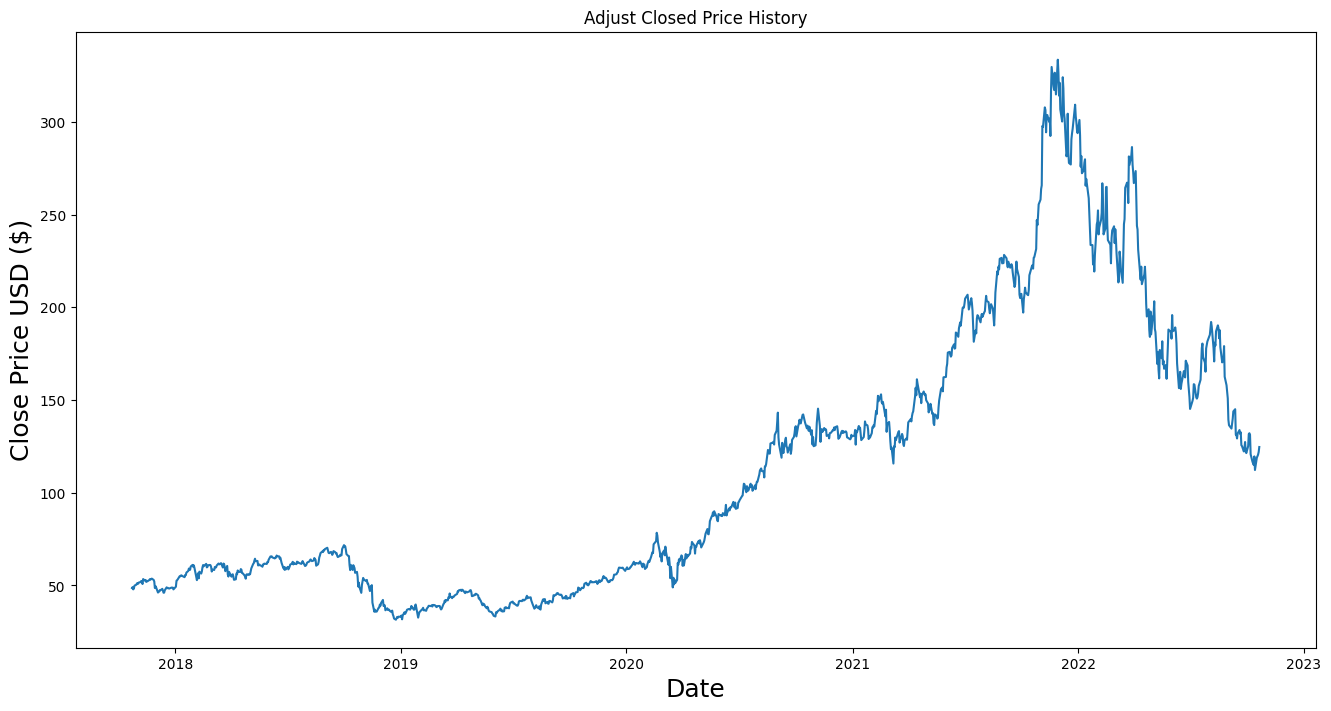

In [94]:
#Visualise the adjusted close history
plt.figure(figsize = (16,8))
plt.title('Adjust Closed Price History')
plt.plot(df)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [95]:
#Use the Augmented Dickey Fuller (ADF) test to check if the price series is stationary
adf_result = adfuller(df.dropna())
print('ADF Statistic: ' + str(adf_result[0]))
print('p-value: ' + str(adf_result[1]))


ADF Statistic: -1.2484330479514658
p-value: 0.6524220167085828


Based on the p-value of 0.6478, which is higher than 0.05 at a 95% level of significance, we are unable to reject the null hypothesis that the model is stationary.

In [96]:
#Run ndiffs to find the optimal level of differencing based on ADF test
ndiffs(df, test = "adf")

1

Using ndiffs from the pmdarima package, we can see that we only need 1 differencing to be able to reject the null hypothesis for the ADF test. Therefore for the parameters of ARIMA, we will choose d = 1

In [97]:
#Conduct hypothesis testing to ensure value of differnecing is approporiate
diff = df.diff().dropna()
adf_result = adfuller(diff.dropna())
print('ADF Statistic: ' + str(adf_result[0]))
print('p-value: ' + str(adf_result[1]))

ADF Statistic: -12.041547354111604
p-value: 2.7248411755074974e-22


Using the ACF plot, we can see what order of q we should use. We can see that lag number 7 is higher than significance line, thus we will use q = 11.

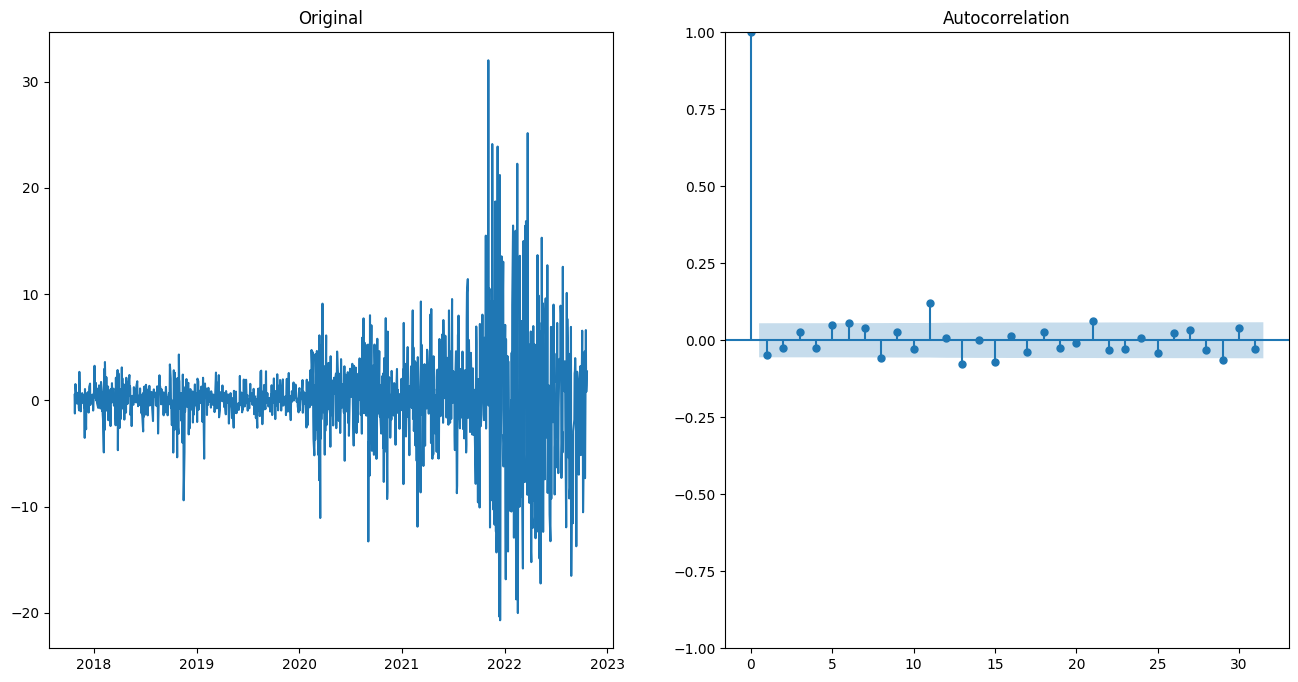

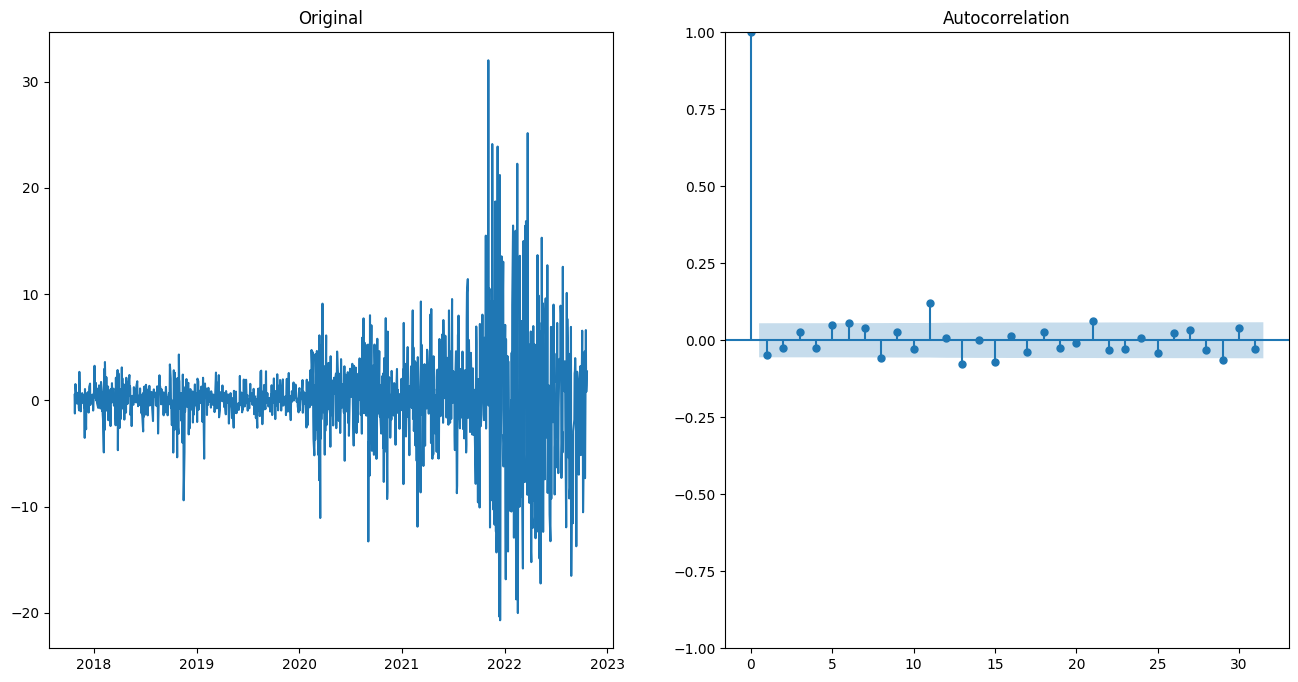

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))
ax1.plot(diff)
ax1.set_title("Original")
plot_acf(diff, ax = ax2)

Using the partial autocorrelation plot, we can see what order of p we should use. We can see that lag number 11 is the highest above the signifinance line, thus we will use p = 11.

c:\Users\65903\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


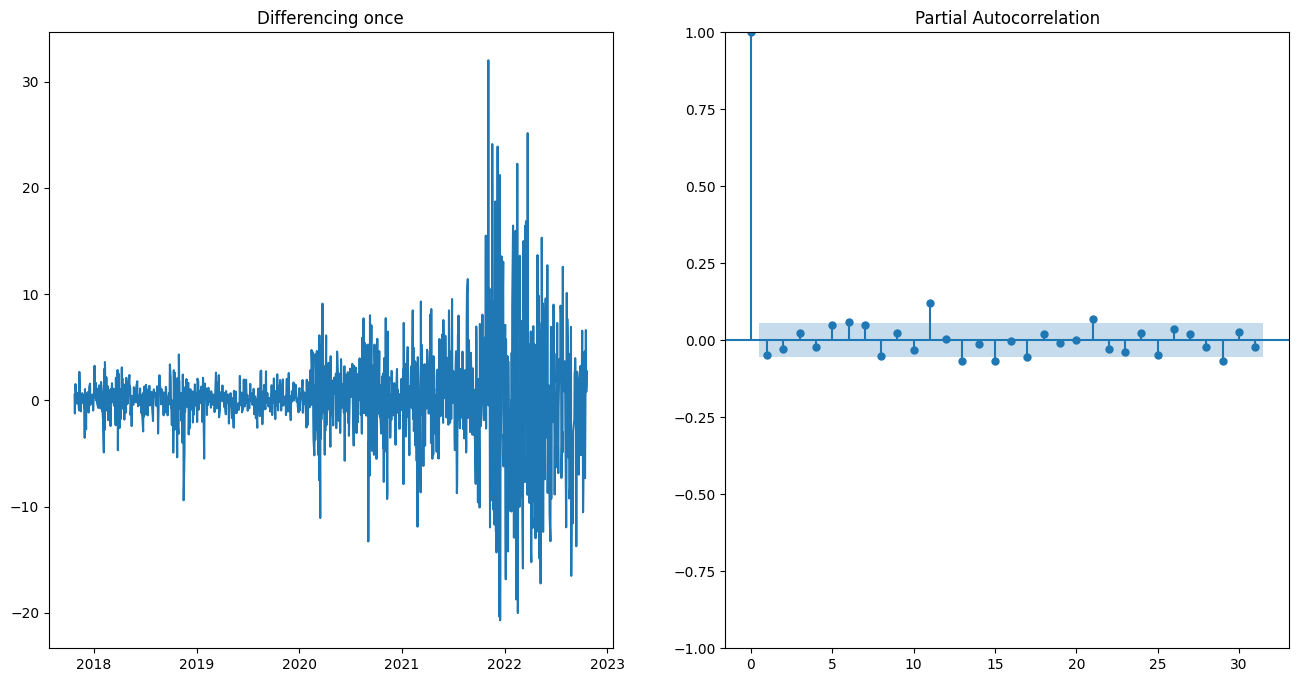

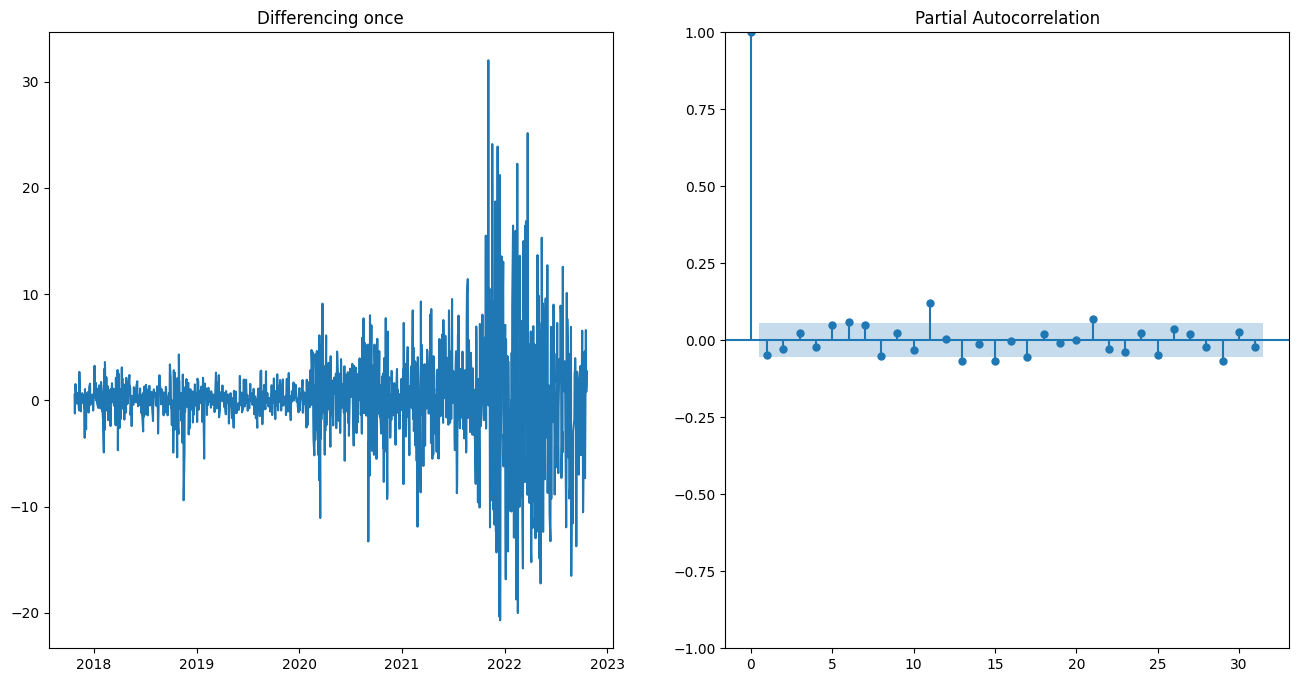

In [99]:
diff = df.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,8))

ax1.plot(diff)
ax1.set_title("Differencing once")
ax2.set_ylim(0,1)
plot_pacf(diff, ax = ax2)

In [102]:
#Train the model based on last 3 years of data
model = ARIMA(df, order = (11,1,11))
result = model.fit()

c:\Users\65903\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\65903\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [103]:
#Check results for any errors
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1259
Model:               ARIMA(11, 1, 11)   Log Likelihood               -3662.316
Date:                Sat, 22 Oct 2022   AIC                           7370.632
Time:                        17:59:00   BIC                           7488.790
Sample:                             0   HQIC                          7415.038
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0247      0.107     -0.231      0.818      -0.234       0.185
ar.L2         -0.1796      0.103     -1.740      0.082      -0.382       0.023
ar.L3         -0.1362      0.107     -1.269      0.204      -0.347       0.074
ar.L4         -0.5499      0.042    -13.096      0.000      -0.632      -0.468
ar.L5         -0.1593      0.078     -2.053      0.040      -0.311      -0.007
ar.L6         -0.3264      0.069     -4.720      0.000      -0.462      -0.191
ar.L7         -0.1514      0.076     -1.985      0.047      -0.301      -0.002
ar.L8         -0.7060      0.039    -18.126      0.000      -0.782      -0.630
ar.L9          0.1256      0.096      1.308      0.191      -0.063       0.314
ar.L10        -0.1533      0.098     -1.568      0.117      -0.345       0.038
ar.L11        -0.2877      0.095     -3.016      0.003      -0.475      -0.101
ma.L1         -0.0066      0.101     -0.065      0.948      -0.205       0.192
ma.L2          0.1472      0.102      1.447      0.148      -0.052       0.346
ma.L3          0.1591      0.102      1.553      0.120      -0.042       0.360
ma.L4          0.5473      0.040     13.629      0.000       0.469       0.626
ma.L5          0.1838      0.076      2.427      0.015       0.035       0.332
ma.L6          0.3730      0.070      5.361      0.000       0.237       0.509
ma.L7          0.1932      0.075      2.569      0.010       0.046       0.341
ma.L8          0.6758      0.041     16.535      0.000       0.596       0.756
ma.L9         -0.1083      0.092     -1.171      0.241      -0.290       0.073
ma.L10         0.1595      0.095      1.680      0.093      -0.027       0.346
ma.L11         0.4436      0.092      4.816      0.000       0.263       0.624
sigma2        19.5768      0.407     48.102      0.000      18.779      20.374
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2688.90
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):              22.41   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
#Using the ARIMA model to predict the next 13 days (inclusive of 23rd October 2022)
step = 13
prediction = result.forecast(step)

c:\Users\65903\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [124]:
#Preparing the data for submission
#Removal of the first row, the prediction of 23rd October 2022
submission = prediction.to_frame()[1:] 
submission = submission.rename({'predicted_mean': 'Close'}, axis=1) 
submission = submission.iloc[:,0:]
submission = submission.reset_index()
submission.to_csv('Alexius_Pooh_Kai_Jie_Impl_2.csv')